In [2]:
# https://www.kaggle.com/shwetabh123/mall-customers

In [86]:
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

from lightgbm import LGBMRegressor

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.style.use('seaborn-deep')
sns.set()


%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [566]:
data = pd.read_csv('Mall_Customers.csv')

## Help function

In [567]:
def std_outliers_plot(df, feature, threshold=3):
    '''This function colculate std outlires and plot this
        
        threshold = 3 - 99.7 %
        threshold = 2 - 95 %
        threshold = 1 - 68 %
        
    '''
    mean, std = np.mean(df), np.std(df)
    z_score = np.abs((df-mean) / std)
    good = z_score < threshold   
    
    print(f'std: threshold = {threshold}\n')
    print(f"Rejection: {(~good).sum()} points\nPercentage of outliers: {round((~good).sum() * 100 / df.size, 4)} %")
    
    visual_scatter = np.random.normal(size=df.size)
    plt.scatter(df[good], visual_scatter[good], s=2, label="Good", color="#4CAF50")
    plt.scatter(df[~good], visual_scatter[~good], s=8, label="Bad", color="#F44336")
    plt.legend(loc='upper right')
    plt.title(feature)
    plt.show();
    
    return good

def lof_outliers_plot(df, feature, threshold=0.5):
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.001, p=1)
    good = lof.fit_predict(df) > threshold
    
    print(f'lof: threshold = {threshold}\n')
    print(f"Rejection {(~good).sum()} points\nPercentage of outliers: {round((~good).sum() * 100 / df.size, 4)} %")
    
    visual_scatter = np.random.normal(size=df.size)
    plt.scatter(df[good], visual_scatter[good], s=2, label="Good", color="#4CAF50")
    plt.scatter(df[~good], visual_scatter[~good], s=8, label="Bad", color="#F44336")
    plt.legend(loc='upper right')
    plt.title(feature)
    plt.show();
    
    return good
    

## Analysis data

In [568]:
data.head(2)

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81


<AxesSubplot:>

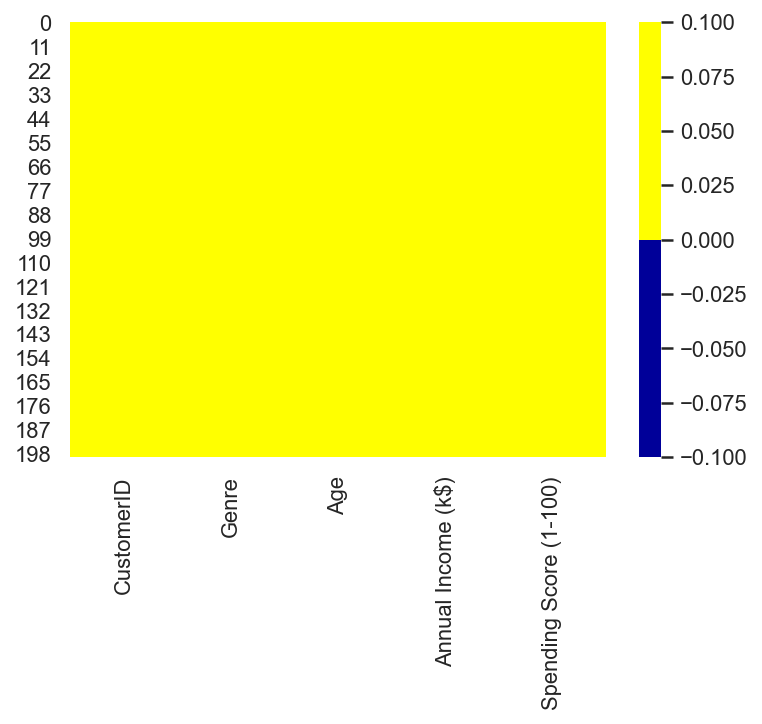

In [569]:
colours = ['#000099', '#ffff00'] 
sns.heatmap(data.isnull(), cmap=sns.color_palette(colours))

<AxesSubplot:>

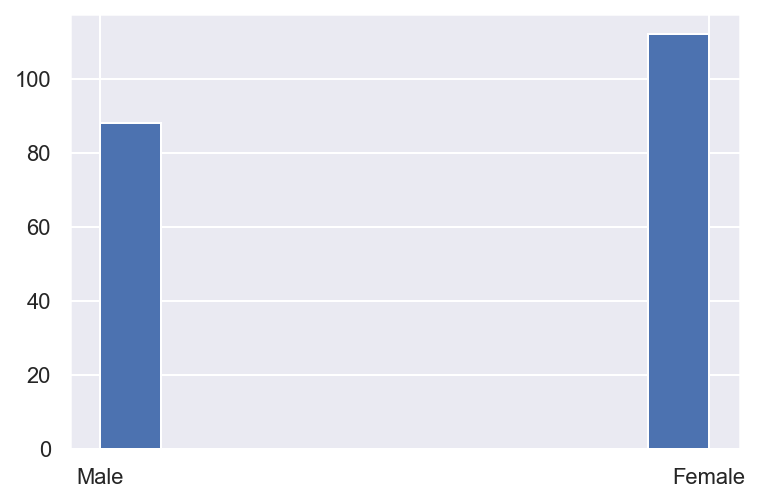

In [570]:
data['Genre'].hist()

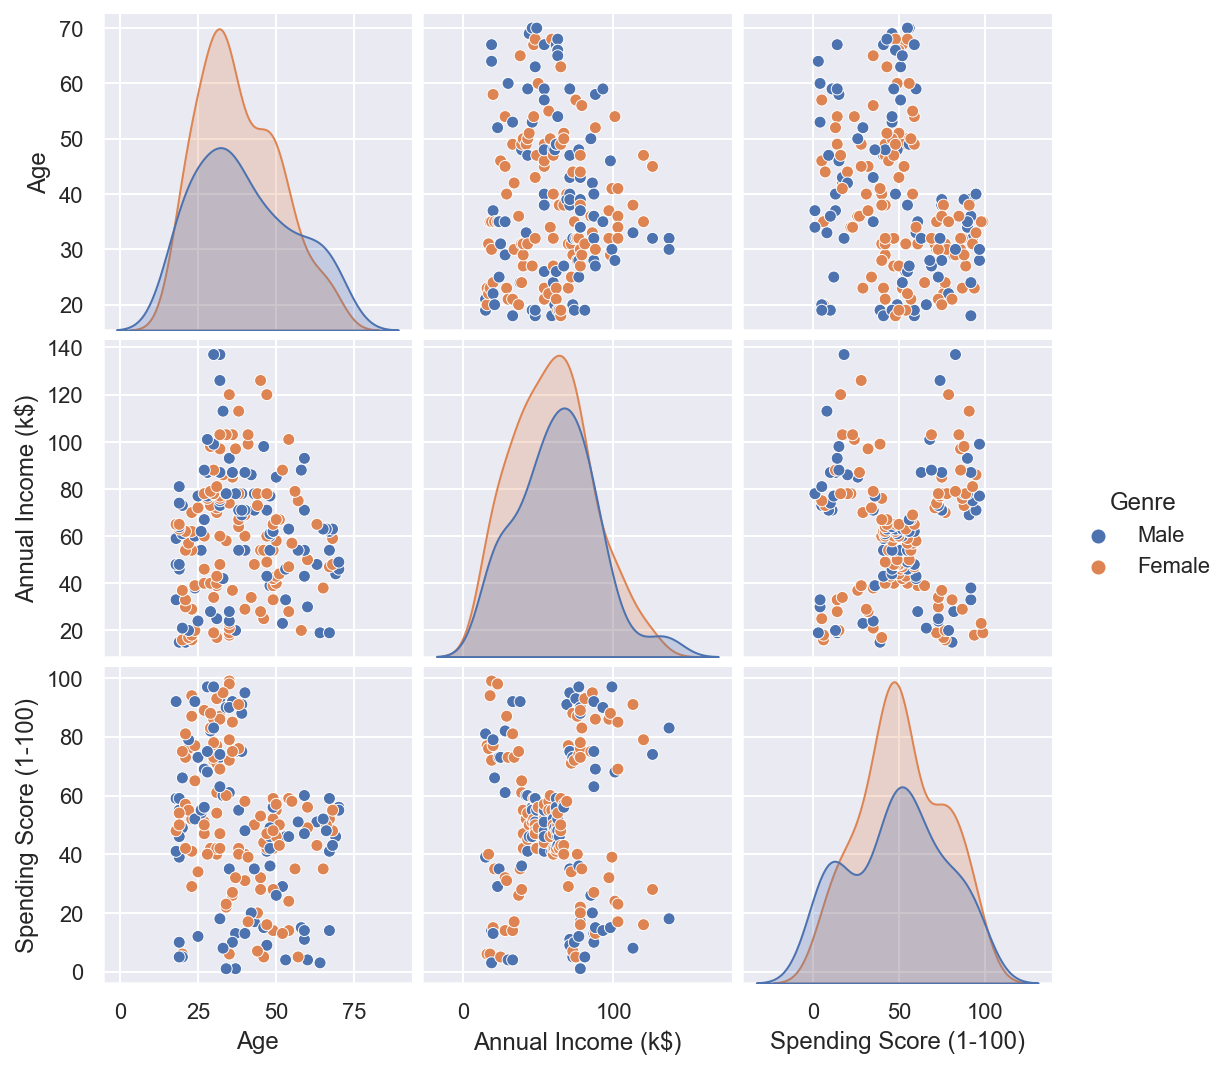

In [571]:
sns.pairplot(data.drop('CustomerID', axis=1), hue='Genre')

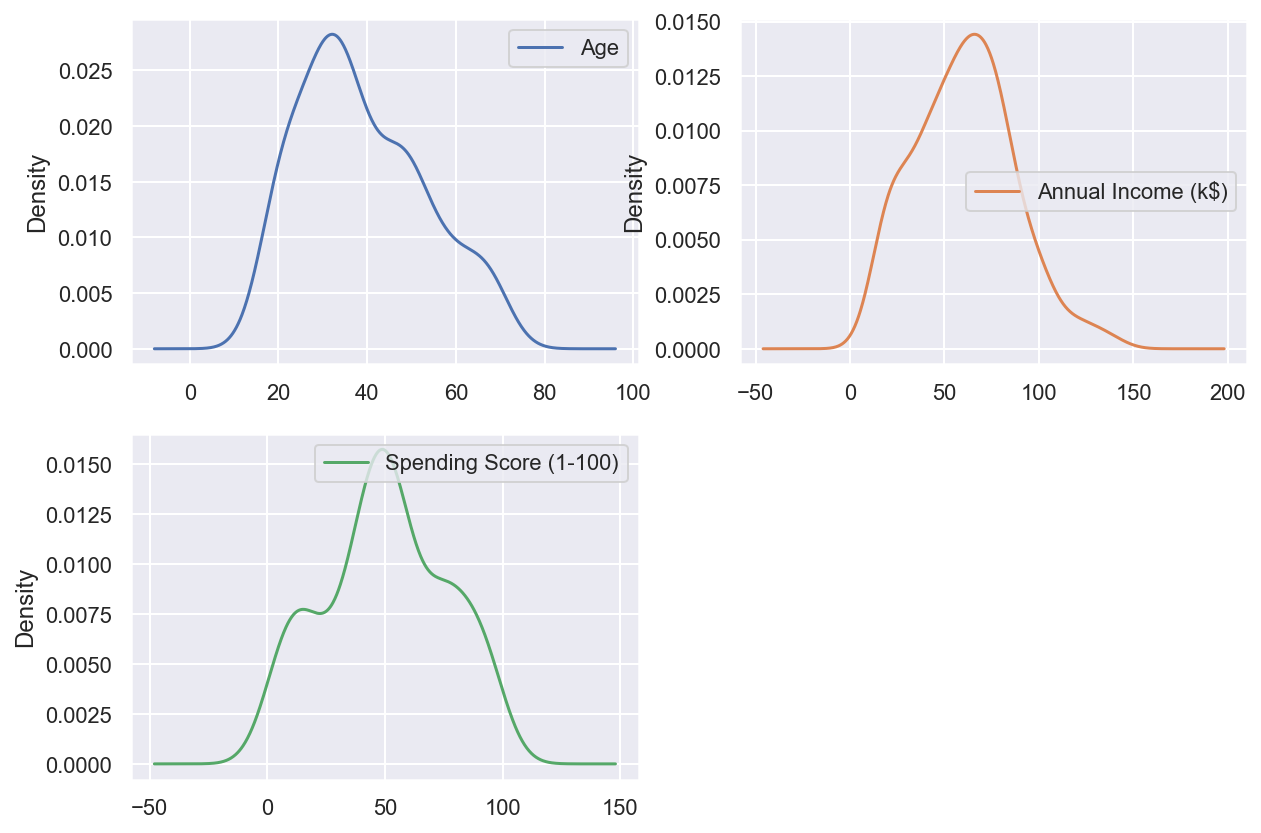

In [572]:
data[data.drop(['CustomerID'], axis=1).columns.tolist()].plot(kind='density', subplots=True, layout=(2, 2), 
                  sharex=False, figsize=(10, 7));

d:\python3.7\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


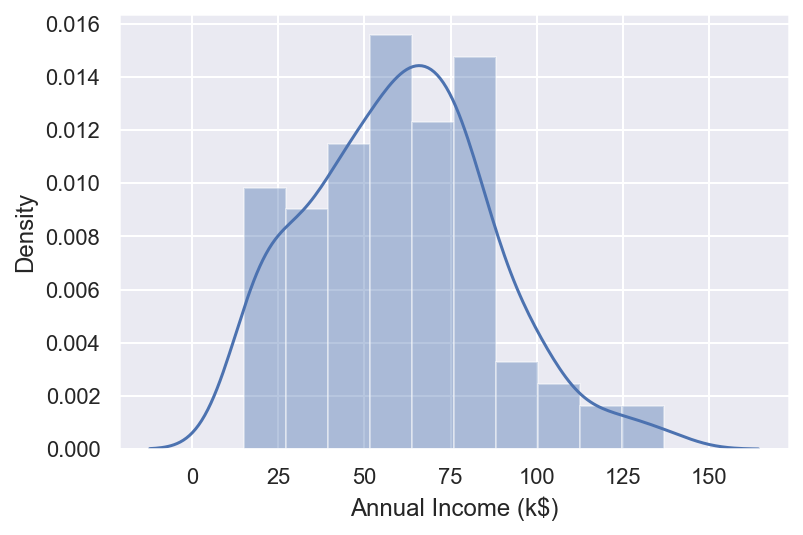

In [573]:
sns.distplot(data['Annual Income (k$)']);

<AxesSubplot:>

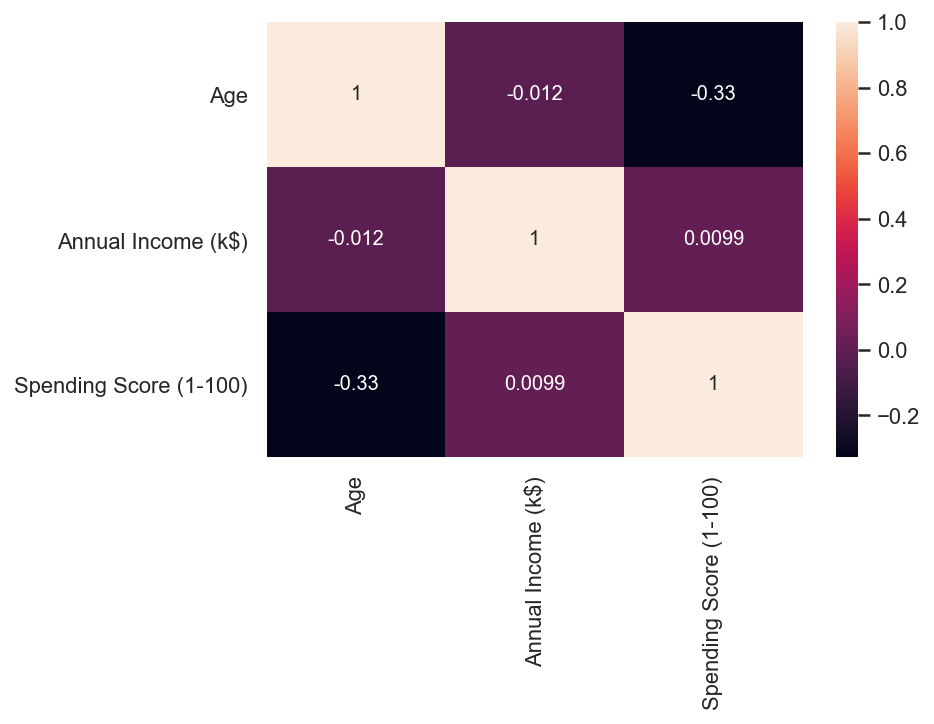

In [576]:
sns.heatmap(data.drop(['CustomerID',], axis=1).corr(), annot=True,)

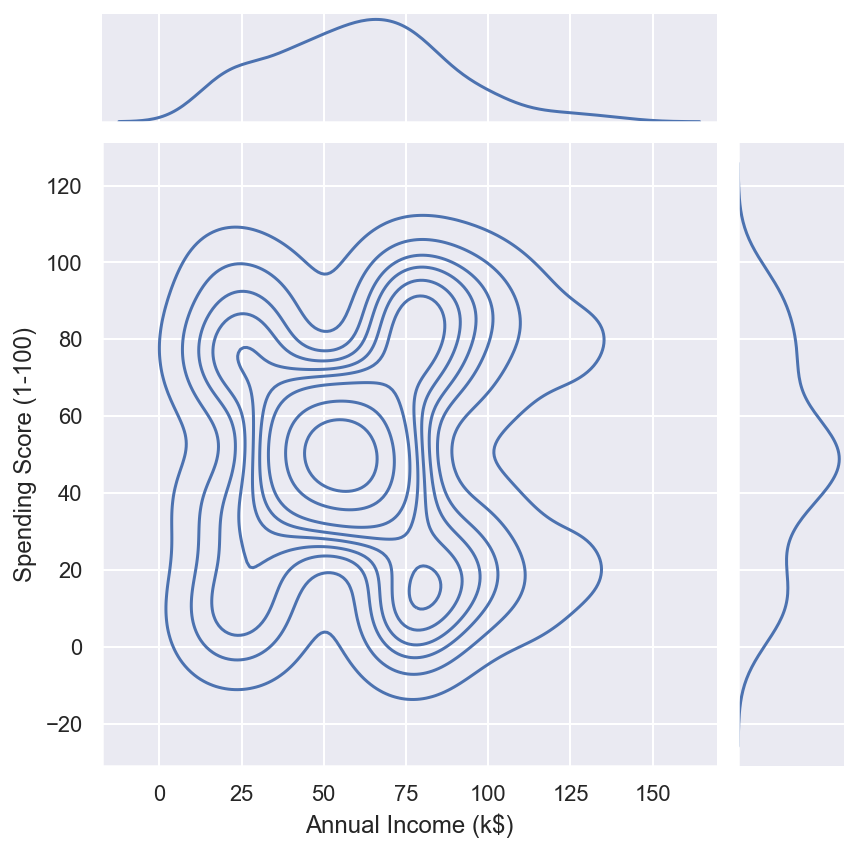

In [577]:
sns.jointplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=data, kind='kde')

In [578]:
X = data.copy()
X['Genre'] = X['Genre'].map({'Male': 1, 'Female': 0})

scaler = StandardScaler()
data_scaled = scaler.fit_transform(X.drop('Spending Score (1-100)', axis=1))

tsne = TSNE(random_state=42)
tsne_repr = tsne.fit_transform(data_scaled)

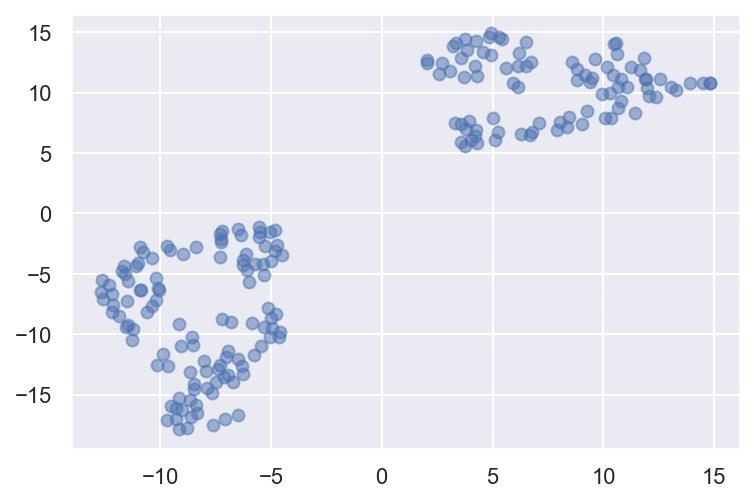

In [579]:
plt.scatter(tsne_repr[:, 0], tsne_repr[:, 1], alpha=.5);

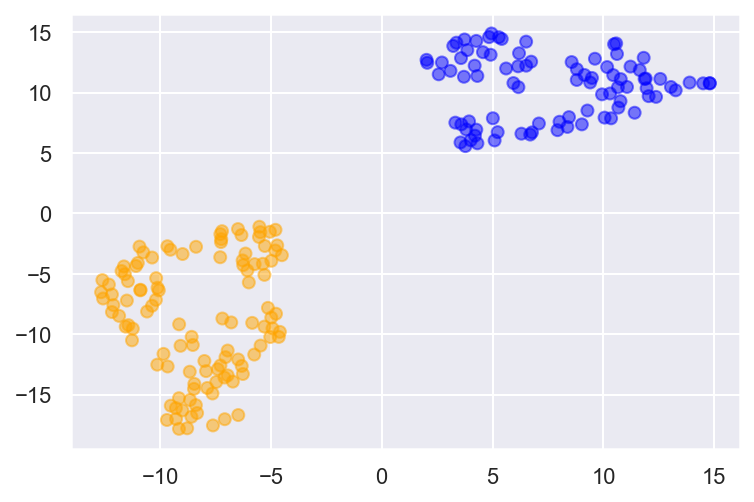

In [580]:
plt.scatter(tsne_repr[:, 0], tsne_repr[:, 1],
            c=X['Genre'].map({1: 'blue', 0: 'orange'}), alpha=.5, );

Age
############################################
std: threshold = 3

Rejection: 0 points
Percentage of outliers: 0.0 %


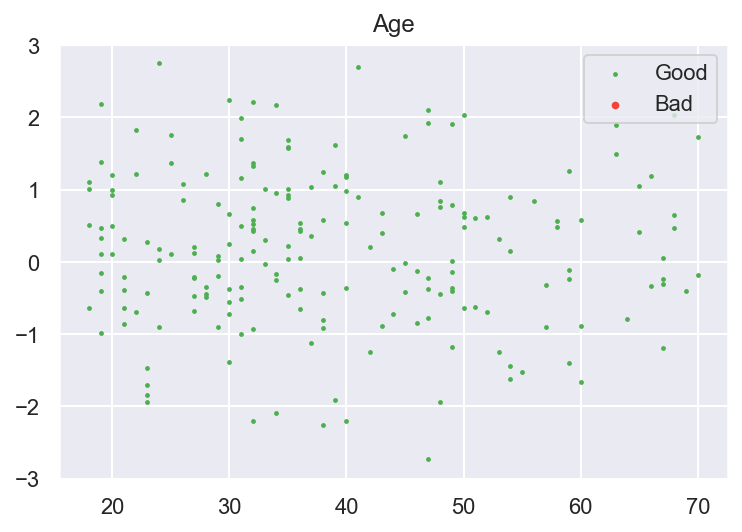

std: threshold = 2

Rejection: 10 points
Percentage of outliers: 5.0 %


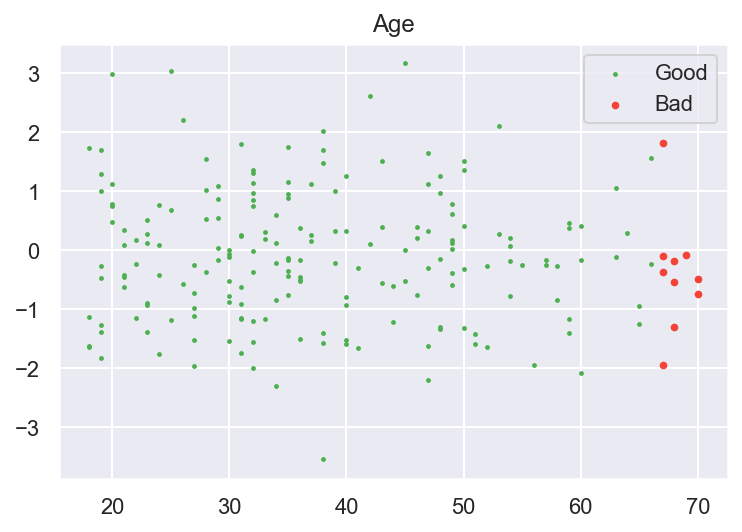

lof: threshold = 0.5

Rejection 0 points
Percentage of outliers: 0.0 %


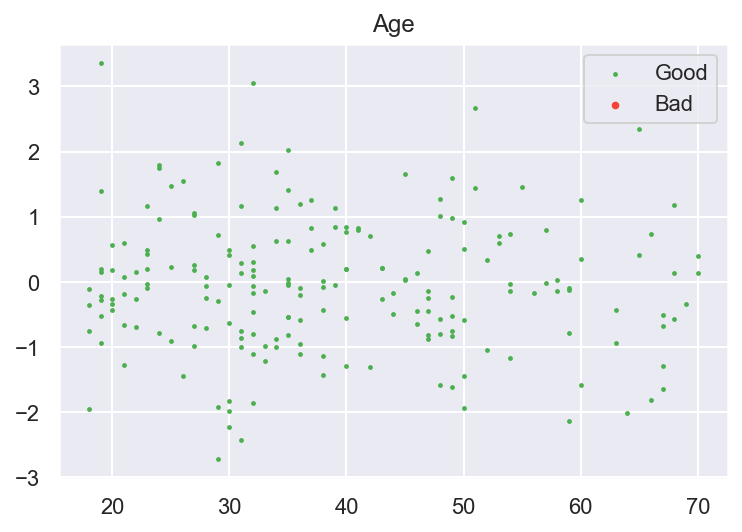

Annual Income (k$)
############################################
std: threshold = 3

Rejection: 0 points
Percentage of outliers: 0.0 %


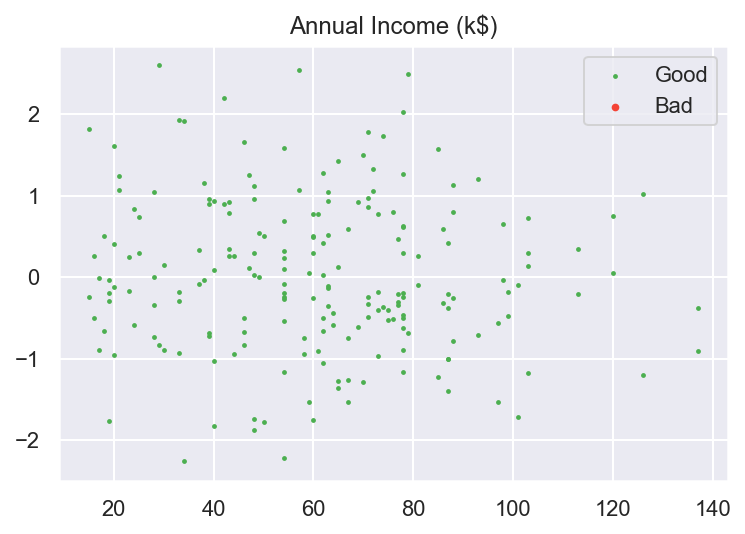

std: threshold = 2

Rejection: 8 points
Percentage of outliers: 4.0 %


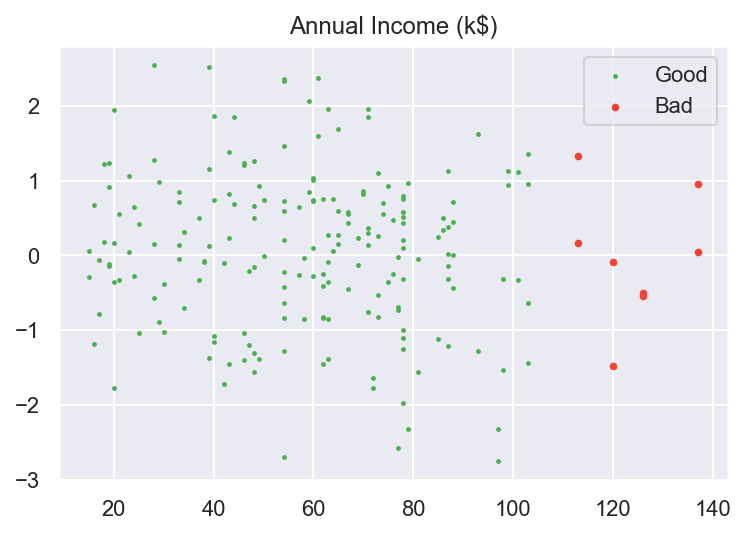

lof: threshold = 0.5

Rejection 0 points
Percentage of outliers: 0.0 %


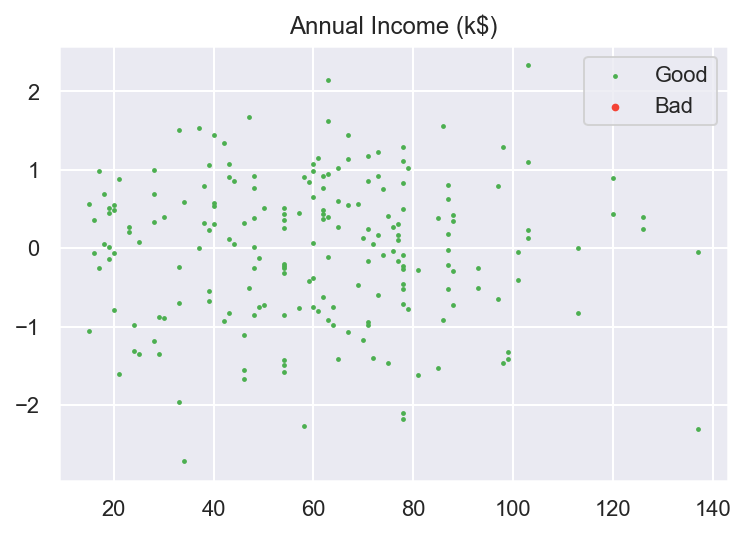

Spending Score (1-100)
############################################
std: threshold = 3

Rejection: 0 points
Percentage of outliers: 0.0 %


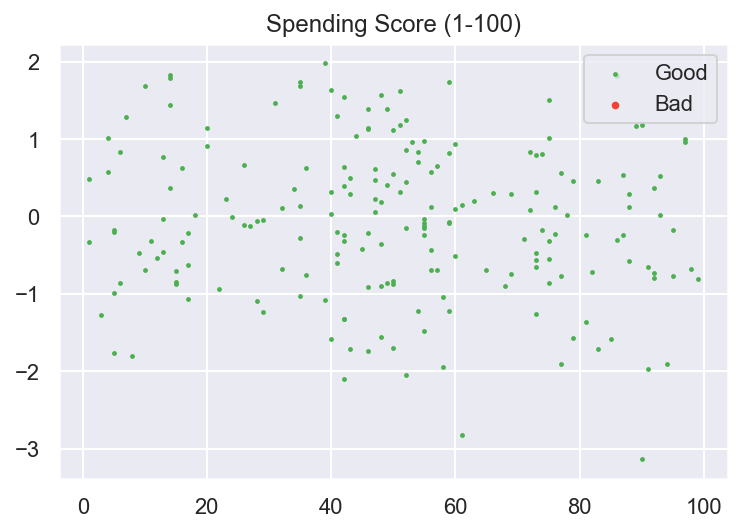

std: threshold = 2

Rejection: 0 points
Percentage of outliers: 0.0 %


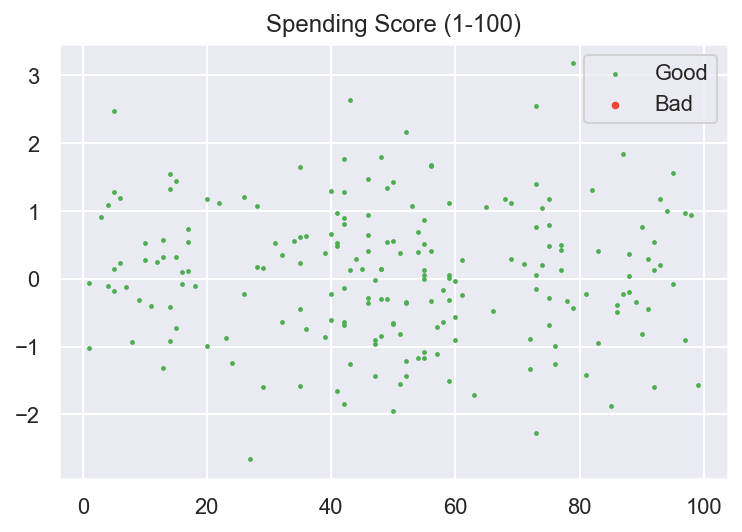

lof: threshold = 0.5

Rejection 1 points
Percentage of outliers: 0.5 %


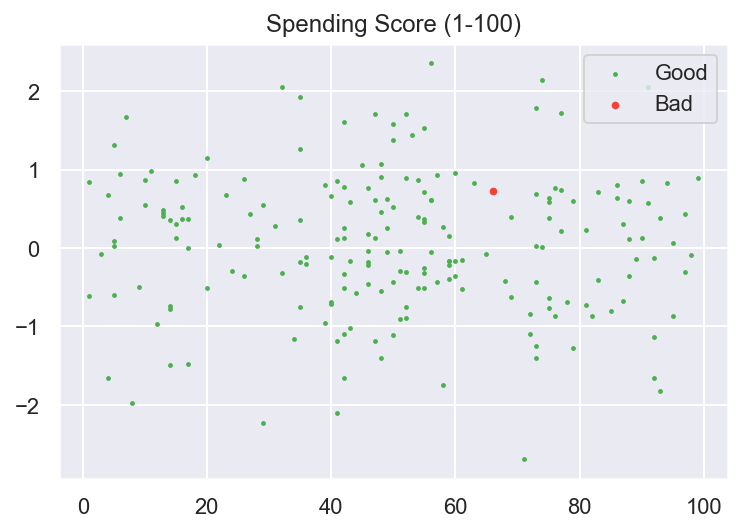

In [581]:
X = data.copy()
X['Genre'] = X['Genre'].map({'Male': 1, 'Female': 0})

for col in X.drop(['Genre', 'CustomerID'], axis=1).columns:
    print(col)
    print('############################################')
    std_target_outliers = std_outliers_plot(data[col], col)
    std_target_outliers = std_outliers_plot(data[col], col, threshold=2)
    lof_target_outliers = lof_outliers_plot(data[col].values.reshape(data[col].shape[0], -1), col)

std: threshold = 3

Rejection: 0 points
Percentage of outliers: 0.0 %


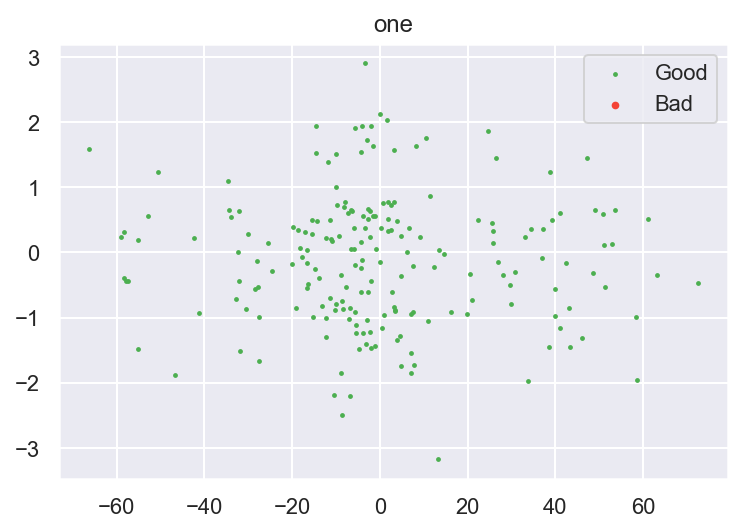

std: threshold = 2

Rejection: 15 points
Percentage of outliers: 7.5 %


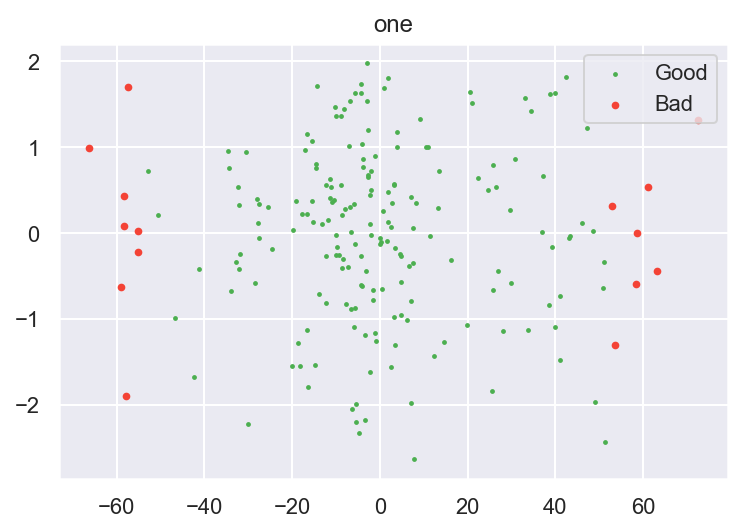

lof: threshold = 0.5

Rejection 1 points
Percentage of outliers: 0.5 %


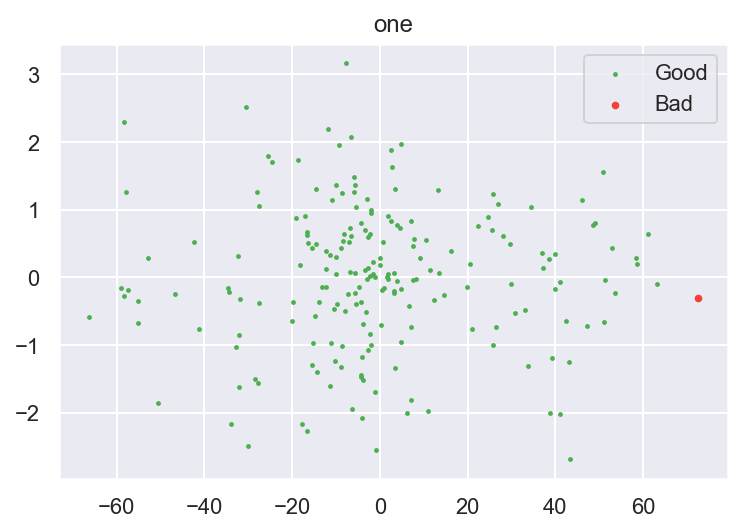

In [582]:
pca = PCA(n_components=1)
XX = pd.DataFrame(pca.fit_transform(X.drop(['Genre', 'CustomerID'], axis=1)), columns=['one'])

std_target_outliers = std_outliers_plot(XX['one'], 'one')
std_target_outliers = std_outliers_plot(XX['one'], 'one', threshold=2)
lof_target_outliers = lof_outliers_plot(XX['one'].values.reshape(XX['one'].shape[0], -1), 'one')

## Predict Spending Score

In [583]:
X = data.copy()

# X['Genre'] = X['Genre'].map({'Male': 1, 'Female': 0})

X = X.drop(['CustomerID'], axis=1)
X = pd.get_dummies(X)

y = X['Spending Score (1-100)']

In [584]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [585]:
lgbm = LGBMRegressor()
lgbm.fit(x_train, y_train)
mean_squared_error(lgbm.predict(x_test), y_test, squared=False)

1.996185038114078

In [586]:
cross_val_score(lgbm, X, y, cv=5, scoring='neg_root_mean_squared_error').mean()

-2.6957758755126875

<AxesSubplot:>

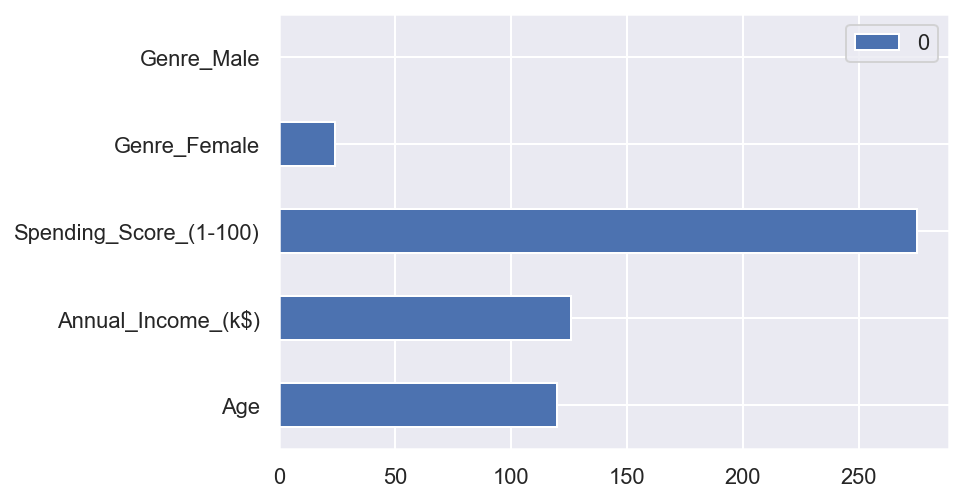

In [587]:
feat_importance_cross = pd.DataFrame(lgbm.feature_importances_, index=lgbm.feature_name_)
feat_importance_cross.plot(kind='barh')

## Simple NN Model?

In [557]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        
        self.fcn1 = nn.Linear(5, 100)
        self.fcn2 = nn.Linear(100, 10)
        self.fcn3 = nn.Linear(10, 1)
    
    def forward(self, x):
        
        x = F.selu(self.fcn1(x))
        x = F.relu(self.fcn2(x))
        x = F.selu(self.fcn3(x))
        
        return x

In [558]:
model = NN()

In [559]:
Xloader = DataLoader(x_train.to_numpy(), batch_size=10, shuffle=False)
yloader = DataLoader(y_train.to_numpy(), batch_size=10, shuffle=False)

Xloader_test = DataLoader(x_test.to_numpy(), batch_size=1, shuffle=False)
yloader_test = DataLoader(y_test.to_numpy(), batch_size=1, shuffle=False)


In [560]:
epochs = 60
loss_step = len(Xloader) // 1
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss()

In [561]:
losses = []

In [562]:
for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    
    for i, (x, y) in tqdm(enumerate(zip(Xloader, yloader)), total=len(Xloader)):
        optimizer.zero_grad()
        
        y_pred = model(x.float())
        
        loss = loss_fn(y_pred, y.float())
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.tolist()
        
        if (i + 1) % loss_step == 0 :
            average_loss = running_loss / loss_step
            
            print('epoch: {0}, step: {1}, loss: {2}'.format(epoch + 1, i + 1, average_loss))
            
            losses.append(average_loss)
            running_loss = 0.0 

epoch: 1, step: 16, loss: 3085.958541870117



d:\python3.7\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 2, step: 16, loss: 2253.6213607788086



epoch: 3, step: 16, loss: 1493.5051879882812



epoch: 4, step: 16, loss: 987.6196403503418



epoch: 5, step: 16, loss: 842.6550769805908



epoch: 6, step: 16, loss: 830.8475036621094



epoch: 7, step: 16, loss: 817.7756099700928



epoch: 8, step: 16, loss: 809.7361011505127



epoch: 9, step: 16, loss: 800.993350982666



epoch: 10, step: 16, loss: 791.6821594238281



epoch: 11, step: 16, loss: 785.0987567901611



epoch: 12, step: 16, loss: 780.269962310791



epoch: 13, step: 16, loss: 776.9804267883301



epoch: 14, step: 16, loss: 774.6673278808594



epoch: 15, step: 16, loss: 773.1213073730469



epoch: 16, step: 16, loss: 771.8045196533203



epoch: 17, step: 16, loss: 770.8140335083008



epoch: 18, step: 16, loss: 769.910774230957



epoch: 19, step: 16, loss: 769.098201751709



epoch: 20, step: 16, loss: 768.3872680664062



epoch: 21, step: 16, loss: 767.5943832397461



epoch: 22, step: 16, loss: 766.9509925842285



epoch: 23, step: 16, loss: 766.2577667236328



epoch: 24, step: 16, loss: 765.6282997131348



epoch: 25, step: 16, loss: 764.9847106933594



epoch: 26, step: 16, loss: 764.3236846923828



epoch: 27, step: 16, loss: 763.6502838134766



epoch: 28, step: 16, loss: 762.9389533996582



epoch: 29, step: 16, loss: 762.1644134521484



epoch: 30, step: 16, loss: 761.4458541870117



epoch: 31, step: 16, loss: 760.7610816955566



epoch: 32, step: 16, loss: 760.0643653869629



epoch: 33, step: 16, loss: 759.3100471496582



epoch: 34, step: 16, loss: 758.5893955230713



epoch: 35, step: 16, loss: 757.8996086120605



epoch: 36, step: 16, loss: 757.2184200286865



epoch: 37, step: 16, loss: 756.5403347015381



epoch: 38, step: 16, loss: 755.8804092407227



epoch: 39, step: 16, loss: 755.1945304870605



epoch: 40, step: 16, loss: 754.4946365356445



epoch: 41, step: 16, loss: 753.8243560791016



epoch: 42, step: 16, loss: 753.1627292633057



epoch: 43, step: 16, loss: 752.4463481903076



epoch: 44, step: 16, loss: 751.7941455841064



epoch: 45, step: 16, loss: 751.0795211791992



epoch: 46, step: 16, loss: 750.4127864837646



epoch: 47, step: 16, loss: 749.7179336547852



epoch: 48, step: 16, loss: 749.0346527099609



epoch: 49, step: 16, loss: 748.2372169494629



epoch: 50, step: 16, loss: 747.7261734008789



epoch: 51, step: 16, loss: 746.8317623138428



epoch: 52, step: 16, loss: 746.3579483032227



epoch: 53, step: 16, loss: 745.4556255340576



epoch: 54, step: 16, loss: 744.9924049377441



epoch: 55, step: 16, loss: 744.0857620239258



epoch: 56, step: 16, loss: 743.620683670044



epoch: 57, step: 16, loss: 742.6153450012207



epoch: 58, step: 16, loss: 741.9668483734131



epoch: 59, step: 16, loss: 741.3577156066895



epoch: 60, step: 16, loss: 740.5155296325684




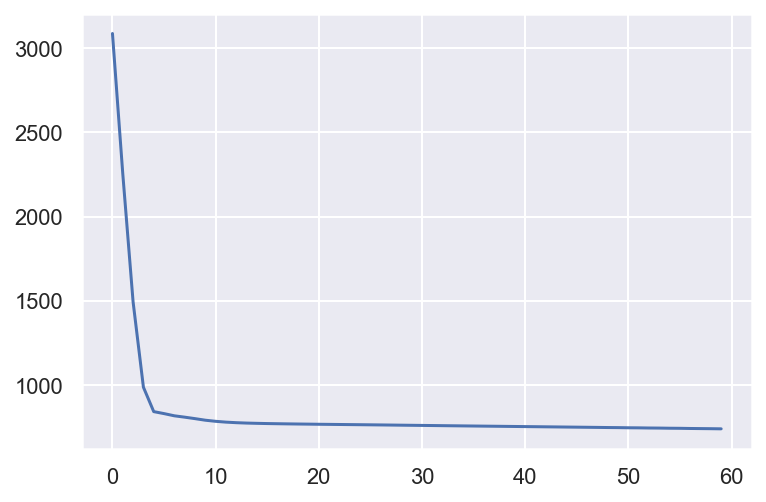

In [563]:
plt.plot(np.arange(len(losses)), losses)

In [564]:
y_preds = []
y_true = []
with torch.no_grad():
    for i, (x, y) in tqdm(enumerate(zip(Xloader_test, yloader_test)), total=len(Xloader_test)):
        y_preds.append(model(x.float()).tolist()[0])
        y_true.append(y.float().tolist()[0])

In [565]:
mean_squared_error(y_true, y_preds, squared=False)

23.127156664155347